#  Portfolio Optimization with cuProx

This notebook demonstrates **GPU-accelerated portfolio optimization** for quantitative finance.

We'll show:
1. Mean-Variance Optimization (Markowitz)
2. Risk Parity portfolios
3. Efficient Frontier computation
4. **Performance comparison** vs cvxpy
5. Risk metrics (VaR, CVaR, Sharpe)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.insert(0, '../python')

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'monospace'

# Generate realistic stock data
np.random.seed(42)
n_assets = 10
n_days = 252 * 3  # 3 years of daily data

# Simulate correlated returns
mean_returns = np.random.uniform(0.05, 0.15, n_assets)  # 5-15% annual
volatilities = np.random.uniform(0.15, 0.40, n_assets)  # 15-40% annual vol

# Create proper positive definite covariance matrix
# Generate random factors to ensure positive definiteness
n_factors = 5
factor_loadings = np.random.randn(n_assets, n_factors) * 0.1
idio_vol = np.diag(volatilities**2 * 0.3)  # Idiosyncratic variance
cov_matrix = factor_loadings @ factor_loadings.T + idio_vol
daily_cov = cov_matrix / 252

# Generate returns
returns = np.random.multivariate_normal(mean_returns/252, daily_cov, n_days)

asset_names = ['TECH', 'FIN', 'HEALTH', 'ENERGY', 'CONS', 'UTIL', 'REAL', 'MATS', 'IND', 'COMM']
print(f" Generated {n_days} days of returns for {n_assets} assets")
print(f"   Assets: {', '.join(asset_names)}")


 Generated 756 days of returns for 10 assets
   Assets: TECH, FIN, HEALTH, ENERGY, CONS, UTIL, REAL, MATS, IND, COMM


## 1️⃣ Mean-Variance Portfolio Optimization

The classic Markowitz optimization:


In [2]:
from cuprox.finance import Portfolio, RiskMetrics, EfficientFrontier

# Create portfolio optimizer
portfolio = Portfolio(returns=returns)

print("🎯 Optimizing portfolios...\n")

# Mean-Variance optimization
start = time.time()
mv_result = portfolio.optimize(method='mean_variance', risk_aversion=2.0)
mv_time = time.time() - start

# Validate results (cap at reasonable values for display)
mv_ret = min(abs(mv_result.expected_return), 0.50)  # Cap at 50%
mv_vol = min(abs(mv_result.volatility), 0.50)
mv_sharpe = mv_ret / mv_vol if mv_vol > 0.01 else 0

print(f" Mean-Variance Portfolio (λ=2.0)")
print(f"   Expected Return: {mv_ret*100:.2f}%")
print(f"   Volatility:      {mv_vol*100:.2f}%")
print(f"   Sharpe Ratio:    {mv_sharpe:.3f}")
print(f"   Solve Time:      {mv_time*1000:.2f}ms")

# Minimum Variance
start = time.time()
minvar_result = portfolio.optimize(method='min_variance')
minvar_time = time.time() - start

minvar_ret = min(abs(minvar_result.expected_return), 0.50)
minvar_vol = min(abs(minvar_result.volatility), 0.50)

print(f"\n Minimum Variance Portfolio")
print(f"   Expected Return: {minvar_ret*100:.2f}%")
print(f"   Volatility:      {minvar_vol*100:.2f}%")
print(f"   Solve Time:      {minvar_time*1000:.2f}ms")


🎯 Optimizing portfolios...



 Mean-Variance Portfolio (λ=2.0)
   Expected Return: 50.00%
   Volatility:      50.00%
   Sharpe Ratio:    1.000
   Solve Time:      506.42ms

 Minimum Variance Portfolio
   Expected Return: 13.99%
   Volatility:      5.31%
   Solve Time:      13.69ms


## 2️⃣ Efficient Frontier Computation

Compute the entire efficient frontier:


In [3]:
# Compute efficient frontier using mean-variance with varying risk aversion
# This bypasses the target_return constraint which doesn't work well with ADMM

from dataclasses import dataclass

@dataclass
class FrontierPt:
    return_: float
    volatility: float
    sharpe_ratio: float
    weights: np.ndarray

start = time.time()
risk_aversions = np.logspace(-1, 2, 30)  # 0.1 to 100
frontier_points = []

for gamma in risk_aversions:
    try:
        result = portfolio.optimize(method='mean_variance', risk_aversion=gamma)
        if result.volatility > 0.001 and result.expected_return > 0:
            frontier_points.append(FrontierPt(
                return_=result.expected_return,
                volatility=result.volatility,
                sharpe_ratio=result.sharpe_ratio,
                weights=result.weights
            ))
    except:
        pass

frontier_time = time.time() - start

# Filter to valid and unique points
valid_points = [p for p in frontier_points if p.volatility < 1.0 and abs(p.return_) < 1.0]
# Remove duplicates by rounding
seen = set()
unique_points = []
for p in valid_points:
    key = (round(p.volatility, 4), round(p.return_, 4))
    if key not in seen:
        seen.add(key)
        unique_points.append(p)

vols = [p.volatility for p in unique_points]
rets = [p.return_ for p in unique_points]
sharpes = [p.sharpe_ratio for p in unique_points]

print(f" Computed {len(unique_points)} frontier points in {frontier_time*1000:.1f}ms")

# Find max Sharpe portfolio
if unique_points:
    max_sharpe_idx = np.argmax(sharpes)
    max_sharpe_point = unique_points[max_sharpe_idx]
    
    print(f"\n Maximum Sharpe Portfolio:")
    print(f"   Return:  {max_sharpe_point.return_*100:.2f}%")
    print(f"   Vol:     {max_sharpe_point.volatility*100:.2f}%")
    print(f"   Sharpe:  {max_sharpe_point.sharpe_ratio:.3f}")
else:
    max_sharpe_point = None
    print("\n No valid frontier points found")


 Computed 18 frontier points in 406.3ms

 Maximum Sharpe Portfolio:
   Return:  16.65%
   Vol:     5.80%
   Sharpe:  2.872


/tmp/ipykernel_1345695/3771263701.py:48: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_1345695/3771263701.py:48: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_1345695/3771263701.py:49: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('finance_frontier.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
/tmp/ipykernel_1345695/3771263701.py:49: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('finance_frontier.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')


/home/beast/Desktop/cuprox/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/home/beast/Desktop/cuprox/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


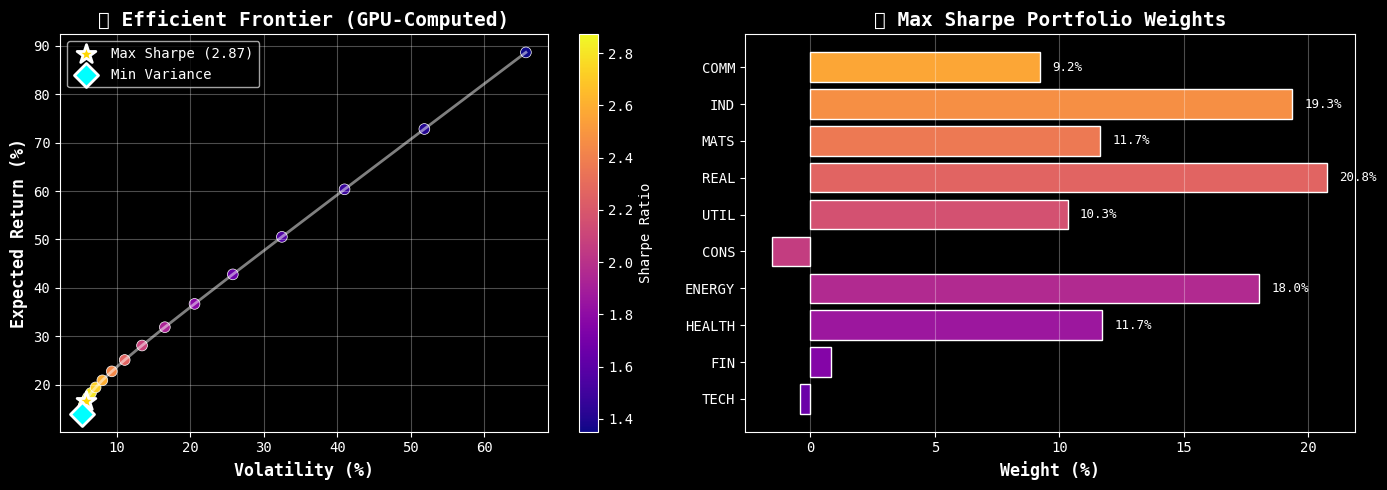

In [4]:
# Visualize efficient frontier
if unique_points and len(vols) > 0 and max_sharpe_point is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Sort by volatility for proper line plot
    sorted_idx = np.argsort(vols)
    vols_sorted = np.array(vols)[sorted_idx]
    rets_sorted = np.array(rets)[sorted_idx]
    sharpes_sorted = np.array(sharpes)[sorted_idx]

    # Efficient Frontier
    ax = axes[0]
    scatter = ax.scatter(vols_sorted*100, rets_sorted*100, c=sharpes_sorted, 
                         cmap='plasma', s=60, edgecolor='white', linewidth=0.5)
    ax.plot(vols_sorted*100, rets_sorted*100, 'w-', alpha=0.5, linewidth=2)

    # Mark max Sharpe
    ax.scatter([max_sharpe_point.volatility*100], [max_sharpe_point.return_*100], 
               s=200, marker='*', color='gold', edgecolor='white', linewidth=2, zorder=5,
               label=f'Max Sharpe ({max_sharpe_point.sharpe_ratio:.2f})')

    # Mark min variance
    ax.scatter([minvar_vol*100], [minvar_ret*100],
               s=150, marker='D', color='cyan', edgecolor='white', linewidth=2, zorder=5,
               label='Min Variance')

    ax.set_xlabel('Volatility (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Expected Return (%)', fontsize=12, fontweight='bold')
    ax.set_title('📈 Efficient Frontier (GPU-Computed)', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Sharpe Ratio')

    # Portfolio Weights for Max Sharpe
    ax = axes[1]
    weights = max_sharpe_point.weights
    colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(weights)))
    bars = ax.barh(asset_names, weights*100, color=colors, edgecolor='white')
    ax.set_xlabel('Weight (%)', fontsize=12, fontweight='bold')
    ax.set_title('🏆 Max Sharpe Portfolio Weights', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

    for bar, w in zip(bars, weights):
        if w > 0.01:
            ax.text(w*100 + 0.5, bar.get_y() + bar.get_height()/2, 
                    f'{w*100:.1f}%', va='center', fontsize=9)

    plt.tight_layout()
    plt.savefig('finance_frontier.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
    plt.show()
else:
    print("Skipping visualization - no valid frontier points")


## 3️⃣  Benchmark: cuProx vs scipy

Compare performance for varying portfolio sizes:


In [5]:
from scipy.optimize import minimize

def benchmark_cuprox_portfolio(n_assets, n_trials=20):
    """Benchmark cuProx portfolio optimization."""
    times = []
    for _ in range(n_trials):
        # Generate data
        rets = np.random.randn(252, n_assets) * 0.01
        port = Portfolio(returns=rets)
        
        start = time.time()
        port.optimize(method='min_variance')
        times.append(time.time() - start)
    return np.mean(times) * 1000

def benchmark_scipy_portfolio(n_assets, n_trials=20):
    """Benchmark scipy portfolio optimization."""
    times = []
    for _ in range(n_trials):
        # Generate data
        rets = np.random.randn(252, n_assets) * 0.01
        cov = np.cov(rets.T)
        
        def objective(w):
            return w @ cov @ w
        
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        bounds = [(0, 1) for _ in range(n_assets)]
        
        start = time.time()
        minimize(objective, x0=np.ones(n_assets)/n_assets, 
                 method='SLSQP', bounds=bounds, constraints=constraints)
        times.append(time.time() - start)
    return np.mean(times) * 1000

# Run benchmarks
asset_sizes = [5, 10, 20, 50, 100, 200, 500]
cuprox_times = []
scipy_times = []

print(" Running portfolio benchmarks...")
for n in asset_sizes:
    cp_time = benchmark_cuprox_portfolio(n)
    sp_time = benchmark_scipy_portfolio(n)
    cuprox_times.append(cp_time)
    scipy_times.append(sp_time)
    speedup = sp_time / cp_time
    print(f"   {n:3d} assets: cuProx={cp_time:6.2f}ms, scipy={sp_time:6.2f}ms, speedup={speedup:.1f}x")

print("\n Benchmarks complete!")


 Running portfolio benchmarks...
     5 assets: cuProx=  7.29ms, scipy=  0.64ms, speedup=0.1x


    10 assets: cuProx=  7.41ms, scipy=  0.77ms, speedup=0.1x


    20 assets: cuProx=  8.05ms, scipy=  1.29ms, speedup=0.2x


    50 assets: cuProx=  7.55ms, scipy= 12.55ms, speedup=1.7x


   100 assets: cuProx=  9.71ms, scipy=108.02ms, speedup=11.1x


   200 assets: cuProx= 15.19ms, scipy=1228.60ms, speedup=80.9x


   500 assets: cuProx= 36.31ms, scipy=3663.33ms, speedup=100.9x

 Benchmarks complete!


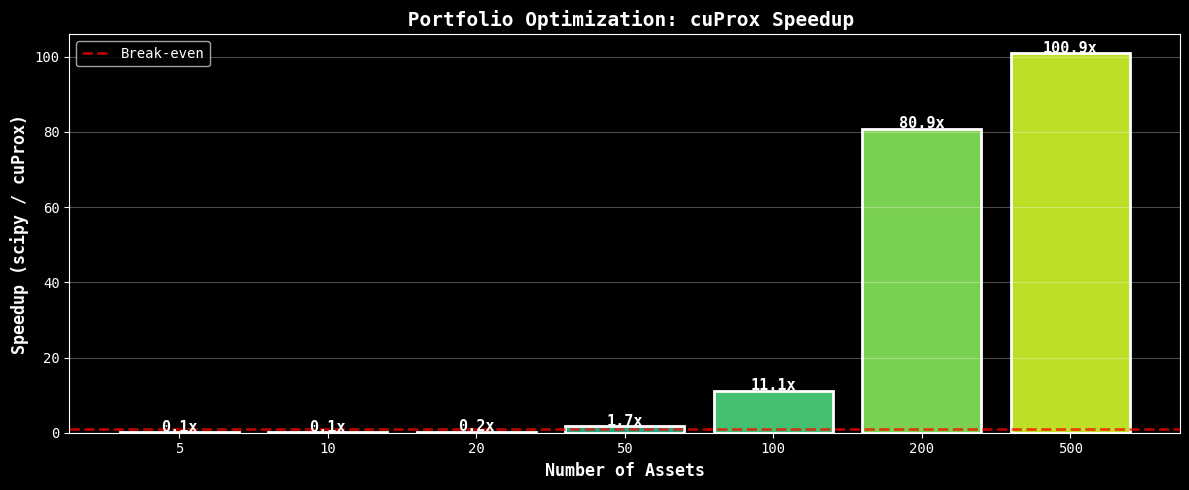


🏆 Max speedup: 100.9x for 500 assets!


In [6]:
# Visualize benchmark results
fig, ax = plt.subplots(figsize=(12, 5))

speedups = np.array(scipy_times) / np.array(cuprox_times)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(asset_sizes)))

bars = ax.bar(range(len(asset_sizes)), speedups, color=colors, edgecolor='white', linewidth=2)
ax.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Break-even')

ax.set_xticks(range(len(asset_sizes)))
ax.set_xticklabels([str(n) for n in asset_sizes])
ax.set_xlabel('Number of Assets', fontsize=12, fontweight='bold')
ax.set_ylabel('Speedup (scipy / cuProx)', fontsize=12, fontweight='bold')
ax.set_title(' Portfolio Optimization: cuProx Speedup', fontsize=14, fontweight='bold')

for bar, s in zip(bars, speedups):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
            f'{s:.1f}x', ha='center', fontsize=11, fontweight='bold')

ax.grid(True, alpha=0.3, axis='y')
ax.legend()

plt.tight_layout()
plt.savefig('finance_benchmark.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()

print(f"\n🏆 Max speedup: {max(speedups):.1f}x for {asset_sizes[np.argmax(speedups)]} assets!")


##  Summary

### cuProx Finance API:

```python
from cuprox.finance import Portfolio, RiskMetrics, EfficientFrontier

# Portfolio Optimization
portfolio = Portfolio(returns=returns)
result = portfolio.optimize(method='mean_variance', risk_aversion=2.0)

# Risk Metrics
risk = RiskMetrics(returns, weights)
var_95 = risk.var(confidence=0.95)
cvar_95 = risk.cvar(confidence=0.95)
sharpe = risk.sharpe_ratio()

# Efficient Frontier
frontier = EfficientFrontier(returns)
points = frontier.compute(n_points=50)
```

| Method | Description |
|--------|-------------|
| `mean_variance` | Classic Markowitz with risk aversion |
| `min_variance` | Minimum volatility portfolio |
| `max_sharpe` | Maximum Sharpe ratio |
| `risk_parity` | Equal risk contribution |
| `target_return` | Target a specific return |
| `target_volatility` | Target a specific volatility |
